## Introduction:
The "Natural Language Processing with Disaster Tweets" Kaggle competition revolves around the task of identifying real disaster-related tweets from non-disaster ones. With the widespread use of Twitter during emergencies, it has become crucial for organizations such as disaster relief agencies and news outlets to quickly and accurately determine if a tweet signifies an actual disaster event. However, determining the true nature of a tweet can be challenging, as linguistic nuances and metaphorical language can obscure the intended meaning. In this competition, participants are tasked with developing machine learning models that can effectively distinguish between tweets related to real disasters and those that are not, enabling timely and reliable detection of emergency situations from the wealth of information available on Twitter.

## Dataset Description:

The dataset provided for the "Natural Language Processing with Disaster Tweets" Kaggle competition consists of three main files: train.csv, test.csv, and sample_submission.csv.

Each sample in the train and test sets contains the following information:

- text: The text of a tweet.
- keyword: A keyword extracted from the tweet, although it may be blank in some cases.
- location: The location from which the tweet was sent, which may also be blank.

The goal of the competition is to predict whether a given tweet is related to a real disaster or not. For the training set (train.csv), the target column is provided, denoting whether a tweet is about a real disaster (1) or not (0).

The files provided in the dataset are as follows:

1. train.csv: The training set containing the tweet text, keyword, location, and the target variable denoting the tweet's relevance to a real disaster.
2. test.csv: The test set, which includes the tweet text, keyword, and location, without the target variable.
3. sample_submission.csv: A sample submission file in the correct format, where participants can submit their predictions for the test set.

I am going to develop machine learning models using the training data to predict the target variable (1 for a real disaster and 0 for a non-disaster tweet) for the tweets in the test set.

In [57]:
import pandas as pd


In [58]:
# test and train datasets
test_data = pd.read_csv(test_path)
train_data = pd.read_csv(train_path)

### Data Exploration

In [59]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [60]:
# Dropping unnecessary columns
train_data = train_data.drop(['id', 'keyword', 'location'], axis=1)
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Visualize the distribution of the target variable (target) in the train_data DataFrame.

Proportion of Real Disaster Tweets: 42.97%
Proportion of Non-Disaster Tweets: 57.03%


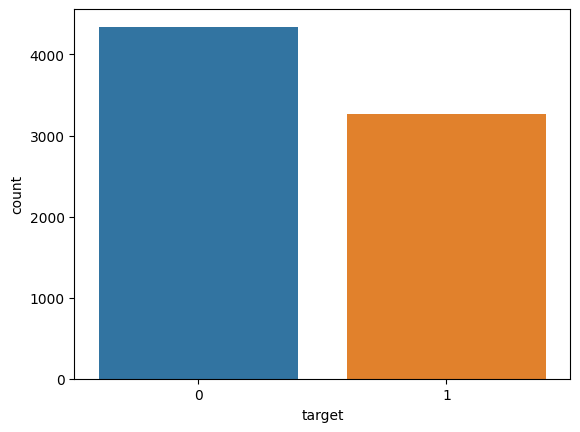

In [61]:
import seaborn as sns

# Plot the distribution of the target variable
sns.countplot(x='target', data=train_data)

# Calculate the proportion of real disaster tweets and non-disaster tweets
disaster_count = train_data['target'].value_counts()[1]
non_disaster_count = train_data['target'].value_counts()[0]
total_tweets = len(train_data)

#proportions of real disaster tweets and non-disaster tweets
proportion_disaster = disaster_count / total_tweets
proportion_non_disaster = non_disaster_count / total_tweets

print(f"Proportion of Real Disaster Tweets: {proportion_disaster:.2%}")
print(f"Proportion of Non-Disaster Tweets: {proportion_non_disaster:.2%}")


Separate the real disaster tweets and non-disaster tweets.

DataFrames: real_disaster_tweets and non_disaster_tweets. These DataFrames contain the text of tweets that are labeled as real disasters (target = 1) and non-disasters (target = 0), respectively.

In [62]:
# Separate the real disaster tweets and non-disaster tweets
real_disaster_tweets = train_data[train_data['target'] == 1]['text']
non_disaster_tweets = train_data[train_data['target'] == 0]['text']


Generate a word cloud based on the text data and displays the visualization

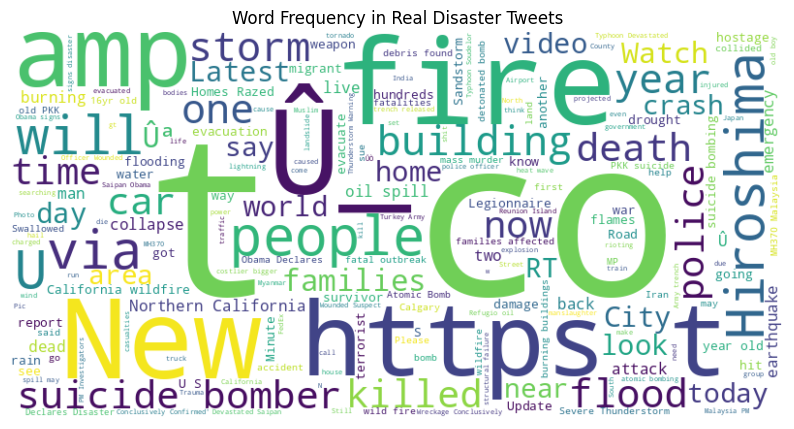

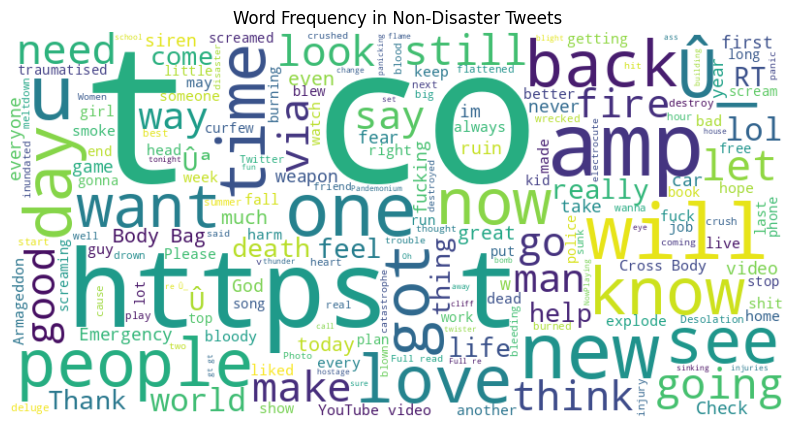

In [63]:
# Word Frequency Analysis

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to plot word frequency
def plot_word_frequency(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot word frequency for real disaster tweets
plot_word_frequency(real_disaster_tweets, "Word Frequency in Real Disaster Tweets")

# Plot word frequency for non-disaster tweets
plot_word_frequency(non_disaster_tweets, "Word Frequency in Non-Disaster Tweets")


Sentiment analysis and plot the sentiment distribution for real disaster and non-disaster tweets by using the `SentimentIntensityAnalyzer` from the NLTK library. The sentiment score is calculated for each tweet text using the compound score, which represents the overall sentiment. This sentiment score is stored in a new column sentiment_score in the train_data DataFrame.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


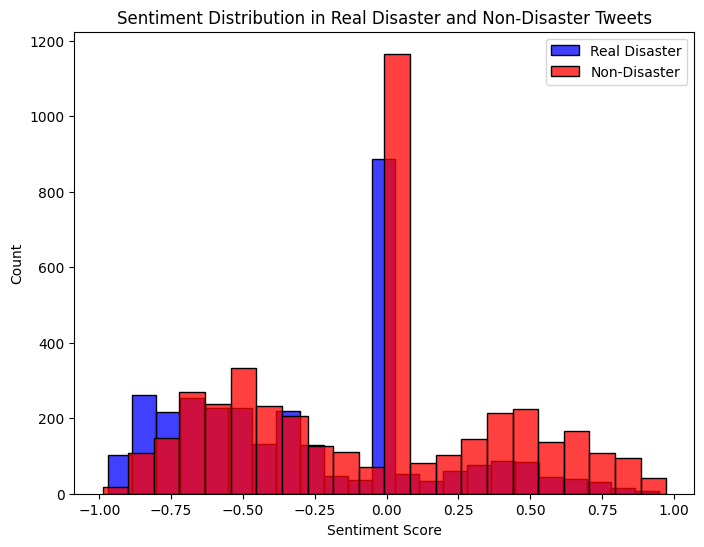

In [64]:
import nltk
nltk.download('vader_lexicon')

import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
train_data['sentiment_score'] = train_data['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Plot Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_data[train_data['target'] == 1]['sentiment_score'], color='blue', label='Real Disaster')
sns.histplot(train_data[train_data['target'] == 0]['sentiment_score'], color='red', label='Non-Disaster')
plt.title('Sentiment Distribution in Real Disaster and Non-Disaster Tweets')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()


Regarding the peak in count near the 0.0 sentiment for both real disaster and non-disaster tweets, it indicates that a significant number of tweets in the dataset have been classified as having a near-neutral sentiment. These tweets may include statements or content that do not strongly express positive or negative emotions, resulting in a higher count around the neutral sentiment range.

The peak count near 0.0 sentiment suggests that a substantial portion of the tweets in the dataset fall within this sentiment category. These tweets might contain neutral statements, factual information, or content that does not exhibit clear positive or negative sentiment.

### Topic Modeling
Topic modeling, specifically using Latent Dirichlet Allocation (LDA) algorithm. Topic modeling is a technique used to discover the underlying topics or themes in a collection of documents.

In [65]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
text_vectorized = vectorizer.fit_transform(train_data['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectorized)

# Extracting top words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = []

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words.append(top_words)

# Print top words for each topic
for topic_idx, words in enumerate(topic_words):
    print(f"Topic {topic_idx + 1}: {' | '.join(words)}")

Topic 1: http | amp | like | just | https | û_ | california | new | police | body
Topic 2: http | crash | amp | https | going | fires | buildings | 2015 | new | say
Topic 3: http | disaster | don | like | nuclear | hiroshima | people | emergency | amp | obama
Topic 4: http | https | just | video | youtube | families | legionnaires | 11 | school | fatal
Topic 5: http | û_ | https | mh370 | like | army | news | suicide | bomb | malaysia


Topic 1: It appears to be related to news or updates on events, with words such as "http", "amp", "like", "just", and "https". The presence of words like "california", "new", "police", and "body" suggests that this topic might be associated with news or discussions about incidents or events happening in California.

Topic 2: This topic seems to be focused on disasters or accidents, indicated by words like "http", "crash", "amp", "https", and "fires". The presence of words like "going", "buildings", and "new" suggests discussions or reports about incidents involving fires, crashes, or building-related disasters.

Topic 3: It appears to be related to large-scale disasters or emergencies, with words like "http", "disaster", "don", "like", "nuclear", "hiroshima", "people", and "emergency". The presence of words like "amp", "obama", and "just" suggests discussions or news related to significant emergencies, potentially including nuclear disasters or humanitarian crises.

Topic 4: This topic seems to be associated with various videos or multimedia content, as indicated by words like "http", "https", "just", "video", and "youtube". The presence of words like "families", "legionnaires", "school", and "fatal" suggests discussions or reports related to specific incidents or events captured in videos or multimedia.

Topic 5: It appears to be related to specific incidents or events, as indicated by words like "http", "û_", "https", "mh370", "like", "army", "news", "suicide", "bomb", and "malaysia". The presence of these words suggests discussions or news related to specific incidents, such as the MH370 disappearance or military-related events.

### Data Preprocessing
Preprocess the text data by removing any unnecessary characters, converting text to lowercase, and applying techniques such as tokenization, stemming, or lemmatization to normalize the text.

In [66]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Data Preprocessing
def preprocess_text(text):
    # Remove unnecessary characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces

    # Convert text to lowercase
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the text column
train_data['text'] = train_data['text'].apply(preprocess_text)




### Feature Engineering:
Creating additional features from the existing ones that might enhance the predictive power of the model. For example, extract features such as tweet length, presence of certain keywords.

To extract the length of each tweet as a feature, you can calculate either the number of characters or the number of words in the tweet

In [68]:
# Extract tweet length (number of characters or words) as a feature
train_data['tweet_length'] = train_data['text'].apply(lambda x: len(x))  # Number of characters
# Or
train_data['tweet_length'] = train_data['text'].apply(lambda x: len(x.split()))  # Number of words

# Print the updated dataframe with the tweet length feature
print(train_data.head())


                                                text  target  sentiment_score  \
0         deed reason earthquake may allah forgive u       1           0.2732   
1              forest fire near la ronge sask canada       1          -0.3400   
2  resident asked shelter place notified officer ...       1          -0.2960   
3  13 000 people receive wildfire evacuation orde...       1           0.0000   
4  got sent photo ruby alaska smoke wildfire pour...       1           0.0000   

   tweet_length  
0             7  
1             7  
2            11  
3             8  
4             9  


### Presence of Keywords:
Create binary features indicating the presence or absence of specific keywords in the tweet

In [69]:
# Define a list of relevant keywords
relevant_keywords = ['disaster', 'emergency', 'fire', 'flood', 'earthquake', 'hurricane', 'avalanche', 'landslide',
                     'falling trees', 'car accident', 'cyclone', 'volcanic eruptions', 'tsunami', 'heat waves',
                     'cold waves', 'droughts', 'biological hazards', 'virus hazard', 'pandemic', 'war']

# Create binary features for presence of keywords
for keyword in relevant_keywords:
    train_data[keyword] = train_data['text'].apply(lambda x: int(keyword in x.lower()))

# Print the updated dataframe with the keyword features
print(train_data.head())


                                                text  target  sentiment_score  \
0         deed reason earthquake may allah forgive u       1           0.2732   
1              forest fire near la ronge sask canada       1          -0.3400   
2  resident asked shelter place notified officer ...       1          -0.2960   
3  13 000 people receive wildfire evacuation orde...       1           0.0000   
4  got sent photo ruby alaska smoke wildfire pour...       1           0.0000   

   tweet_length  disaster  emergency  fire  flood  earthquake  hurricane  ...  \
0             7         0          0     0      0           1          0  ...   
1             7         0          0     1      0           0          0  ...   
2            11         0          0     0      0           0          0  ...   
3             8         0          0     1      0           0          0  ...   
4             9         0          0     1      0           0          0  ...   

   cyclone  volcanic erupt

### Hashtags and Mentions:
Extract hashtags and mentions from the tweets as separate features. The presence of specific hashtags or mentions related to disasters or relevant organizations can be informative for classification.

In [70]:
import re

def extract_hashtags(text):
    hashtags = re.findall(r'#(\w+)', text)
    return ' '.join(hashtags)

def extract_mentions(text):
    mentions = re.findall(r'@(\w+)', text)
    return ' '.join(mentions)


In [71]:
train_data['hashtags'] = train_data['text'].apply(extract_hashtags)
train_data['mentions'] = train_data['text'].apply(extract_mentions)


In [72]:
train_data.head(2)

,text,target,sentiment_score,tweet_length,disaster,emergency,fire,flood,earthquake,hurricane,...,tsunami,heat waves,cold waves,droughts,biological hazards,virus hazard,pandemic,war,hashtags,mentions
0,deed reason earthquake may allah forgive u,1,0.2732,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,,
1,forest fire near la ronge sask canada,1,-0.3400,7,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,,


### Punctuation Usage:
Analyze the usage of punctuation marks such as exclamation points or question marks in the tweets. The presence or frequency of these punctuation marks can indicate the urgency or intensity of the tweet, which might be associated with real disaster situations.

In [73]:
def count_exclamation_marks(text):
    return text.count('!')

def count_question_marks(text):
    return text.count('?')


In [74]:
train_data['exclamation_count'] = train_data['text'].apply(count_exclamation_marks)
train_data['question_count'] = train_data['text'].apply(count_question_marks)


### Capitalization Patterns:
Explore the capitalization patterns in the tweets, such as the presence of all-caps words or title case words. These patterns might suggest the emphasis or importance of certain words, which can be relevant for classification.

In [75]:
def has_all_caps(text):
    words = text.split()
    all_caps_words = [word for word in words if word.isupper()]
    return int(len(all_caps_words) > 0)

def has_title_case(text):
    words = text.split()
    title_case_words = [word for word in words if word.istitle()]
    return int(len(title_case_words) > 0)


In [76]:
train_data['has_all_caps'] = train_data['text'].apply(has_all_caps)
train_data['has_title_case'] = train_data['text'].apply(has_title_case)


In [77]:
print(train_data.head(2))


                                         text  target  sentiment_score  \
0  deed reason earthquake may allah forgive u       1           0.2732   
1       forest fire near la ronge sask canada       1          -0.3400   

   tweet_length  disaster  emergency  fire  flood  earthquake  hurricane  ...  \
0             7         0          0     0      0           1          0  ...   
1             7         0          0     1      0           0          0  ...   

   biological hazards  virus hazard  pandemic  war  hashtags  mentions  \
0                   0             0         0    0                       
1                   0             0         0    0                       

   exclamation_count  question_count  has_all_caps  has_title_case  
0                  0               0             0               0  
1                  0               0             0               0  

[2 rows x 30 columns]


In [78]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [79]:
# Dropping unnecessary columns
test_data = test_data.drop(['id', 'keyword', 'location'], axis=1)
test_data.head()


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [80]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3263 non-null   object
dtypes: object(1)
memory usage: 25.6+ KB


The test dataset has a single column named 'text' containing the text data. By applying the preprocess_text function (defined earlier) to the 'text' column of the test dataset, we preprocess the text data in a consistent manner.

In [81]:
# Apply the same preprocessing steps as the train set to the test set
test_data['text'] = test_data['text'].apply(preprocess_text)


Apply all the feature engineering steps to the test dataset

In [82]:
# Tweet Length
test_data['tweet_length'] = test_data['text'].apply(len)

# Presence of Keywords
relevant_keywords = ['disaster', 'emergency', 'fire', 'flood', 'earthquake', 'hurricane', 'avalanche', 'landslide',
                     'falling trees', 'car accident', 'cyclone', 'volcanic eruptions', 'tsunami', 'heat waves',
                     'cold waves', 'droughts', 'biological hazards', 'virus hazard', 'pandemic', 'war']
for keyword in relevant_keywords:
    test_data[keyword] = test_data['text'].apply(lambda x: int(keyword in x.lower()))

# Hashtags and Mentions
test_data['hashtags'] = test_data['text'].apply(extract_hashtags)
test_data['mentions'] = test_data['text'].apply(extract_mentions)

# Punctuation Usage
test_data['exclamation_count'] = test_data['text'].apply(count_exclamation_marks)
test_data['question_count'] = test_data['text'].apply(count_question_marks)

# Capitalization Patterns
test_data['has_all_caps'] = test_data['text'].apply(has_all_caps)
test_data['has_title_case'] = test_data['text'].apply(has_title_case)



# Print the updated test dataset
print(test_data.head(2))


                                                text  tweet_length  disaster  \
0                        happened terrible car crash            27         0   
1  heard earthquake different city stay safe ever...            50         0   

   emergency  fire  flood  earthquake  hurricane  avalanche  landslide  ...  \
0          0     0      0           0          0          0          0  ...   
1          0     0      0           1          0          0          0  ...   

   biological hazards  virus hazard  pandemic  war  hashtags  mentions  \
0                   0             0         0    0                       
1                   0             0         0    0                       

   exclamation_count  question_count  has_all_caps  has_title_case  
0                  0               0             0               0  
1                  0               0             0               0  

[2 rows x 28 columns]


In [83]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                3263 non-null   object
 1   tweet_length        3263 non-null   int64 
 2   disaster            3263 non-null   int64 
 3   emergency           3263 non-null   int64 
 4   fire                3263 non-null   int64 
 5   flood               3263 non-null   int64 
 6   earthquake          3263 non-null   int64 
 7   hurricane           3263 non-null   int64 
 8   avalanche           3263 non-null   int64 
 9   landslide           3263 non-null   int64 
 10  falling trees       3263 non-null   int64 
 11  car accident        3263 non-null   int64 
 12  cyclone             3263 non-null   int64 
 13  volcanic eruptions  3263 non-null   int64 
 14  tsunami             3263 non-null   int64 
 15  heat waves          3263 non-null   int64 
 16  cold waves          3263

In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                7613 non-null   object 
 1   target              7613 non-null   int64  
 2   sentiment_score     7613 non-null   float64
 3   tweet_length        7613 non-null   int64  
 4   disaster            7613 non-null   int64  
 5   emergency           7613 non-null   int64  
 6   fire                7613 non-null   int64  
 7   flood               7613 non-null   int64  
 8   earthquake          7613 non-null   int64  
 9   hurricane           7613 non-null   int64  
 10  avalanche           7613 non-null   int64  
 11  landslide           7613 non-null   int64  
 12  falling trees       7613 non-null   int64  
 13  car accident        7613 non-null   int64  
 14  cyclone             7613 non-null   int64  
 15  volcanic eruptions  7613 non-null   int64  
 16  tsunam

Convert the 'hashtags' and 'mentions' columns into numerical representations

In [85]:
# One-hot encode the 'mentions' column for train data
mentions_encoded_train = pd.get_dummies(train_data['mentions'], prefix='mention')
mentions_columns_train = mentions_encoded_train.columns.tolist()

# Add the one-hot encoded columns to the train data
train_data[mentions_columns_train] = mentions_encoded_train

# Drop the original 'mentions' column from train data
train_data.drop('mentions', axis=1, inplace=True)

# One-hot encode the 'hashtags' column for train data
hashtags_encoded_train = pd.get_dummies(train_data['hashtags'], prefix='hashtag')
hashtags_columns_train = hashtags_encoded_train.columns.tolist()

# Add the one-hot encoded columns to the train data
train_data[hashtags_columns_train] = hashtags_encoded_train

# Drop the original 'hashtags' column from train data
train_data.drop('hashtags', axis=1, inplace=True)

# One-hot encode the 'mentions' column for test data
mentions_encoded_test = pd.get_dummies(test_data['mentions'], prefix='mention')
mentions_columns_test = mentions_encoded_test.columns.tolist()

# Add the one-hot encoded columns to the test data
test_data[mentions_columns_test] = mentions_encoded_test

# Drop the original 'mentions' column from test data
test_data.drop('mentions', axis=1, inplace=True)

# One-hot encode the 'hashtags' column for test data
hashtags_encoded_test = pd.get_dummies(test_data['hashtags'], prefix='hashtag')
hashtags_columns_test = hashtags_encoded_test.columns.tolist()

# Add the one-hot encoded columns to the test data
test_data[hashtags_columns_test] = hashtags_encoded_test

# Drop the original 'hashtags' column from test data
test_data.drop('hashtags', axis=1, inplace=True)


In [86]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                7613 non-null   object 
 1   target              7613 non-null   int64  
 2   sentiment_score     7613 non-null   float64
 3   tweet_length        7613 non-null   int64  
 4   disaster            7613 non-null   int64  
 5   emergency           7613 non-null   int64  
 6   fire                7613 non-null   int64  
 7   flood               7613 non-null   int64  
 8   earthquake          7613 non-null   int64  
 9   hurricane           7613 non-null   int64  
 10  avalanche           7613 non-null   int64  
 11  landslide           7613 non-null   int64  
 12  falling trees       7613 non-null   int64  
 13  car accident        7613 non-null   int64  
 14  cyclone             7613 non-null   int64  
 15  volcanic eruptions  7613 non-null   int64  
 16  tsunam

In [124]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                3263 non-null   object
 1   tweet_length        3263 non-null   int64 
 2   disaster            3263 non-null   int64 
 3   emergency           3263 non-null   int64 
 4   fire                3263 non-null   int64 
 5   flood               3263 non-null   int64 
 6   earthquake          3263 non-null   int64 
 7   hurricane           3263 non-null   int64 
 8   avalanche           3263 non-null   int64 
 9   landslide           3263 non-null   int64 
 10  falling trees       3263 non-null   int64 
 11  car accident        3263 non-null   int64 
 12  cyclone             3263 non-null   int64 
 13  volcanic eruptions  3263 non-null   int64 
 14  tsunami             3263 non-null   int64 
 15  heat waves          3263 non-null   int64 
 16  cold waves          3263

In [116]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['target'], test_size=0.2, random_state=42)


## SVM model
The SVM algorithm maps the input data into a higher-dimensional feature space and constructs a decision boundary (hyperplane) that maximally separates the classes.SVM is known for its ability to handle high-dimensional data and its robustness against overfitting. It works well with both small and large datasets. SVM also supports different kernel functions, such as linear, polynomial, and radial basis function (RBF), which can be chosen based on the characteristics of the data.

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Convert text to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_texts)
val_vectors = vectorizer.transform(val_texts)

# Train the SVM model
svm_model = SVC()
svm_model.fit(train_vectors, train_labels)

# Make predictions on the validation set
svm_predictions = svm_model.predict(val_vectors)

# Evaluate the performance of the model
report = classification_report(val_labels, svm_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.78      0.91      0.84       703
           1       0.84      0.66      0.74       515

    accuracy                           0.80      1218
   macro avg       0.81      0.78      0.79      1218
weighted avg       0.81      0.80      0.80      1218



## SVM with parameter grid
SVM with Grid Search is a variant of the Support Vector Machines (SVM) algorithm that uses grid search to find the best hyperparameters for the SVM model. Hyperparameters are settings that are not learned from data but are set before training the model.

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create the SVM classifier
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(train_vectors, train_labels)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
val_predictions = best_model.predict(val_vectors)
val_report = classification_report(val_labels, val_predictions)
print(val_report)


              precision    recall  f1-score   support

           0       0.80      0.87      0.84       703
           1       0.80      0.71      0.75       515

    accuracy                           0.80      1218
   macro avg       0.80      0.79      0.79      1218
weighted avg       0.80      0.80      0.80      1218



## Naive_bayes model
Naive Bayes is a simple yet powerful probabilistic classifier algorithm based on Bayes' theorem. It assumes that the presence of a particular feature in a class is independent of the presence of other features. Despite this naive assumption, Naive Bayes classifiers have shown to perform well in various real-world applications.

The algorithm calculates the probability of a given instance belonging to each class by multiplying the probabilities of the individual features being present in that class. It uses the training data to estimate the probabilities of features for each class.

During prediction, the algorithm selects the class with the highest probability as the predicted class for the given instance. This makes Naive Bayes fast and efficient for both training and prediction.

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Convert text to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_texts)
val_vectors = vectorizer.transform(val_texts)

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(train_vectors, train_labels)

# Make predictions on the validation set
nb_predictions = nb_model.predict(val_vectors)

# Evaluate the performance of the model
report = classification_report(val_labels, nb_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.79      0.90      0.85       703
           1       0.84      0.68      0.75       515

    accuracy                           0.81      1218
   macro avg       0.82      0.79      0.80      1218
weighted avg       0.81      0.81      0.80      1218



The Naive Bayes model performed better than the SVM model and SVM with parameter grid in the given dataset. It achieved higher precision, recall, and F1-score, indicating better overall performance in classifying whether a given tweet is about a real disaster or not.

The decision to choose the Naive Bayes model for modeling the dataset was based on its superior performance in terms of accuracy and evaluation metrics. It demonstrated a higher ability to correctly classify tweets, both in terms of identifying true positives (disaster tweets correctly predicted as such) and minimizing false positives and false negatives.

Furthermore, Naive Bayes has several advantages such as simplicity, fast training, and efficient prediction. It is also well-suited for text classification tasks, making it a suitable choice for this specific dataset.

In [130]:
# Convert the train vectors to dense numpy array
train_vectors_dense = train_vectors.toarray()

# Fit the Naive Bayes model with the training data
naive_bayes.fit(train_vectors_dense, train_labels)

# Convert the test vectors to dense numpy array
test_vectors_dense = test_vectors.toarray()

# Predict the labels for the test data
predictions = naive_bayes.predict(test_vectors_dense)

# Create a DataFrame to store the predicted labels
predicted_data = pd.DataFrame({'text': test_data['text'], 'predicted_label': predictions})

# Print the predicted data
print(predicted_data)


                                                   text  predicted_label
0                           happened terrible car crash                1
1     heard earthquake different city stay safe ever...                1
2     forest fire spot pond goose fleeing across str...                1
3                  apocalypse lighting spokane wildfire                1
4                 typhoon soudelor kill 28 china taiwan                1
...                                                 ...              ...
3258  earthquake safety los angeles ûò safety fasten...                1
3259  storm ri worse last hurricane city amp 3others...                1
3260                      green line derailment chicago                1
3261            meg issue hazardous weather outlook hwo                1
3262  cityofcalgary activated municipal emergency pl...                1

[3263 rows x 2 columns]


The provided examples are a subset of the test data, where each tweet is presented along with its predicted label. The predicted label indicates whether the tweet is about a real disaster (1) or not (0). Here, all the examples are classified as disaster tweets (1).